In [2]:
import sys
sys.path.append("../../")

import bayesflow as bf
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from bayesflow.experimental.rectifiers import RectifiedDistribution
from summary import CustomSummary
from evaluation import eval_performance
from amortizers import ConsistencyAmortizer, ConfigurableMLP, DriftNetwork

## Data Loading and Configuration

In [3]:
def read_offline_data(obs_path, param_path, validation_ratio: float = 0.02):
    assert(len(obs_path) == len(param_path))
    observables = []
    params = []
    for i in range(len(obs_path)):
        observables.append(pd.read_pickle(obs_path[i]))
        params.append(pd.read_pickle(param_path[i]))
    obs = np.stack(pd.concat(observables).to_numpy())
    tumor_size = np.stack(obs[:,0])[:, :, None].astype(np.float32)
    radial_features = np.stack([np.stack(obs[:,1]),np.stack(obs[:,2])], axis=-1)[:,:300,:].astype(np.float32)
    params = pd.concat(params).to_numpy().astype(np.float32)
    split = int(validation_ratio * params.shape[0])
    train = {"prior_draws": params[split:], 
             "sim_data": radial_features[split:], 
             'growth_curve': tumor_size[split:]}
    validation = {"prior_draws": params[:split], 
                  "sim_data": radial_features[:split], 
                  'growth_curve': tumor_size[:split]}    
    return train, validation

In [4]:
def configure_input(forward_dict):
    """Custom configurator."""
    
    out_dict = {}
    pp_ecmp = (forward_dict['sim_data'] - MEAN_SIM) / STD_SIM
    pp_ecmp = np.c_[pp_ecmp, [POSITIONAL_EMBEDDINGS]*pp_ecmp.shape[0]]
    growth =  (forward_dict['growth_curve'] - MEAN_GROWTH) / STD_GROWTH 
    params = forward_dict['prior_draws']
    
    out_dict = {
        'summary_conditions': (pp_ecmp, growth),
        'parameters': params
    }    
    return out_dict

In [5]:
train_data, val_data = read_offline_data(
    obs_path=['../../tumor_data/observables_10000_1.pkl', '../../tumor_data/observables_10000_2.pkl'],
    param_path=['../../tumor_data/params_10000_1.pkl', '../../tumor_data/params_10000_2.pkl']
)

In [9]:
MEAN_GROWTH = train_data['growth_curve'].mean((0, 1))
STD_GROWTH = train_data['growth_curve'].std((0, 1))
MEAN_SIM = train_data['sim_data'].mean((0, 1))
STD_SIM = train_data['sim_data'].std((0, 1))
MEAN_PARAMS = train_data['prior_draws'].mean((0, 1))
STD_PARAMS = train_data['prior_draws'].mean((0, 1))

## Networks

In [10]:
BATCH_SIZE = 64
EPOCHS = 1000
POSITIONAL_EMBEDDINGS = np.linspace(0, 1, train_data['sim_data'].shape[1], dtype=np.float32)[:, None]

In [11]:
ITERATIONS = int(np.ceil((train_data['sim_data'].shape[0] / BATCH_SIZE))*EPOCHS)

In [12]:
summary_net = CustomSummary()

inference_net = ConfigurableMLP(
    input_dim=train_data['prior_draws'].shape[-1],
    condition_dim=32,
    hidden_dim=512,
    num_hidden=4,
    dropout_rate=0.2,
)

amortizer = ConsistencyAmortizer(
    consistency_net=inference_net, 
    num_steps=ITERATIONS, 
    summary_net=summary_net,
    sigma2=tf.math.reduce_variance(train_data['prior_draws'], axis=0, keepdims=True),
    T_max=50
)

2023-12-06 19:09:58.434788: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-06 19:09:58.451880: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-06 19:09:58.452008: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

## Consistency Trainer

In [13]:
trainer = bf.trainers.Trainer(
    amortizer=amortizer,
    configurator=configure_input,
    checkpoint_path='ckpt/cm1k',
)

INFO:root:Trainer initialization: No generative model provided. Only offline learning mode is available!
INFO:root:Loaded loss history from ckpt/cm1k/history_1000.pkl.
INFO:root:Networks loaded from ckpt/cm1k/ckpt-1000


In [10]:
# h = trainer.train_offline(
#     train_data, 
#     epochs=EPOCHS,
#     batch_size=BATCH_SIZE, 
#     validation_sims=val_data
# )

## Quick Validation

In [14]:
conf = configure_input(val_data)

In [15]:
conf = configure_input(val_data)
p2 = eval_performance(conf, amortizer, n_samples=2000, scale=(MEAN_PARAMS, STD_PARAMS), n_steps=2)
p30 = eval_performance(conf, amortizer, n_samples=2000, scale=(MEAN_PARAMS, STD_PARAMS), n_steps=30)

2023-12-06 19:10:07.972350: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-12-06 19:10:08.123959: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [16]:
p2

{'time': 2.163225315976888,
 'MaxECE': 0.06368421052631579,
 'MeanECE': 0.03462406015037593,
 'MedianECE': 0.026973684210526316,
 'MinECE': 0.022697368421052633,
 'RMSE': 0.6156072}

In [17]:
p30

{'time': 18.325570826011244,
 'MaxECE': 0.02092105263157895,
 'MeanECE': 0.012875939849624053,
 'MedianECE': 0.013026315789473678,
 'MinECE': 0.006513157894736825,
 'RMSE': 0.57729673}

In [18]:
samples = amortizer.sample(conf, n_samples=1000, n_steps=2, to_numpy=False)

/home/radevs/anaconda3/envs/BayesFlowDev/lib/python3.10/site-packages/seaborn/axisgrid.py:64: UserWarning: The figure layout has changed to tight
  self.fig.tight_layout(*args, **kwargs)


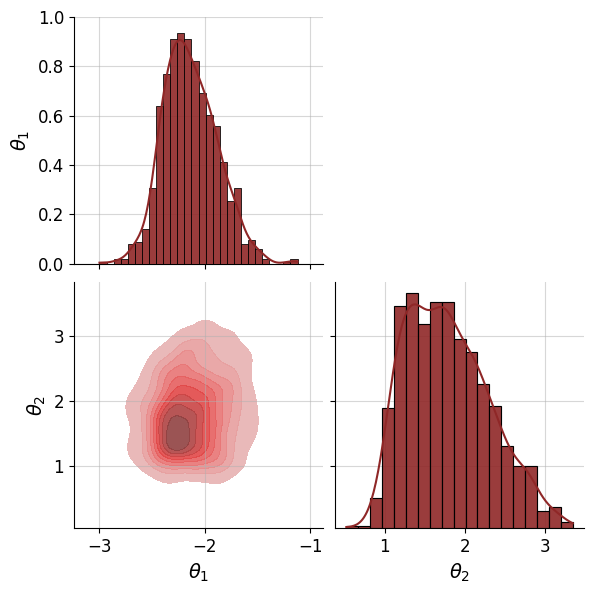

In [25]:
f = bf.diagnostics.plot_posterior_2d(
    samples[0, :, :2]
)

In [17]:
samples = amortizer.sample(conf, n_samples=500, n_steps=5, to_numpy=False)

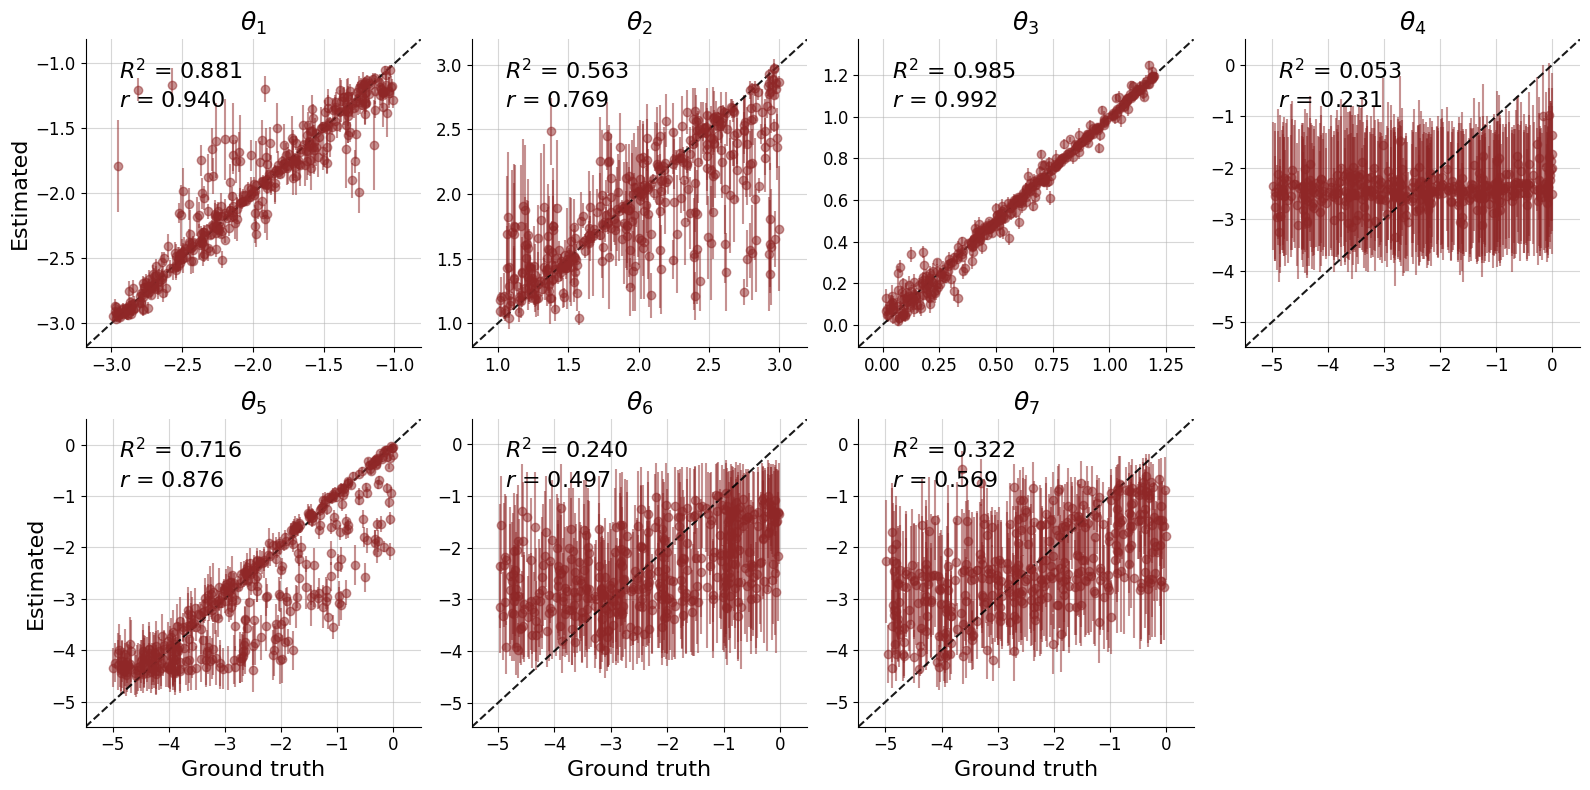

In [18]:
f = bf.diagnostics.plot_recovery(samples, conf['parameters'])

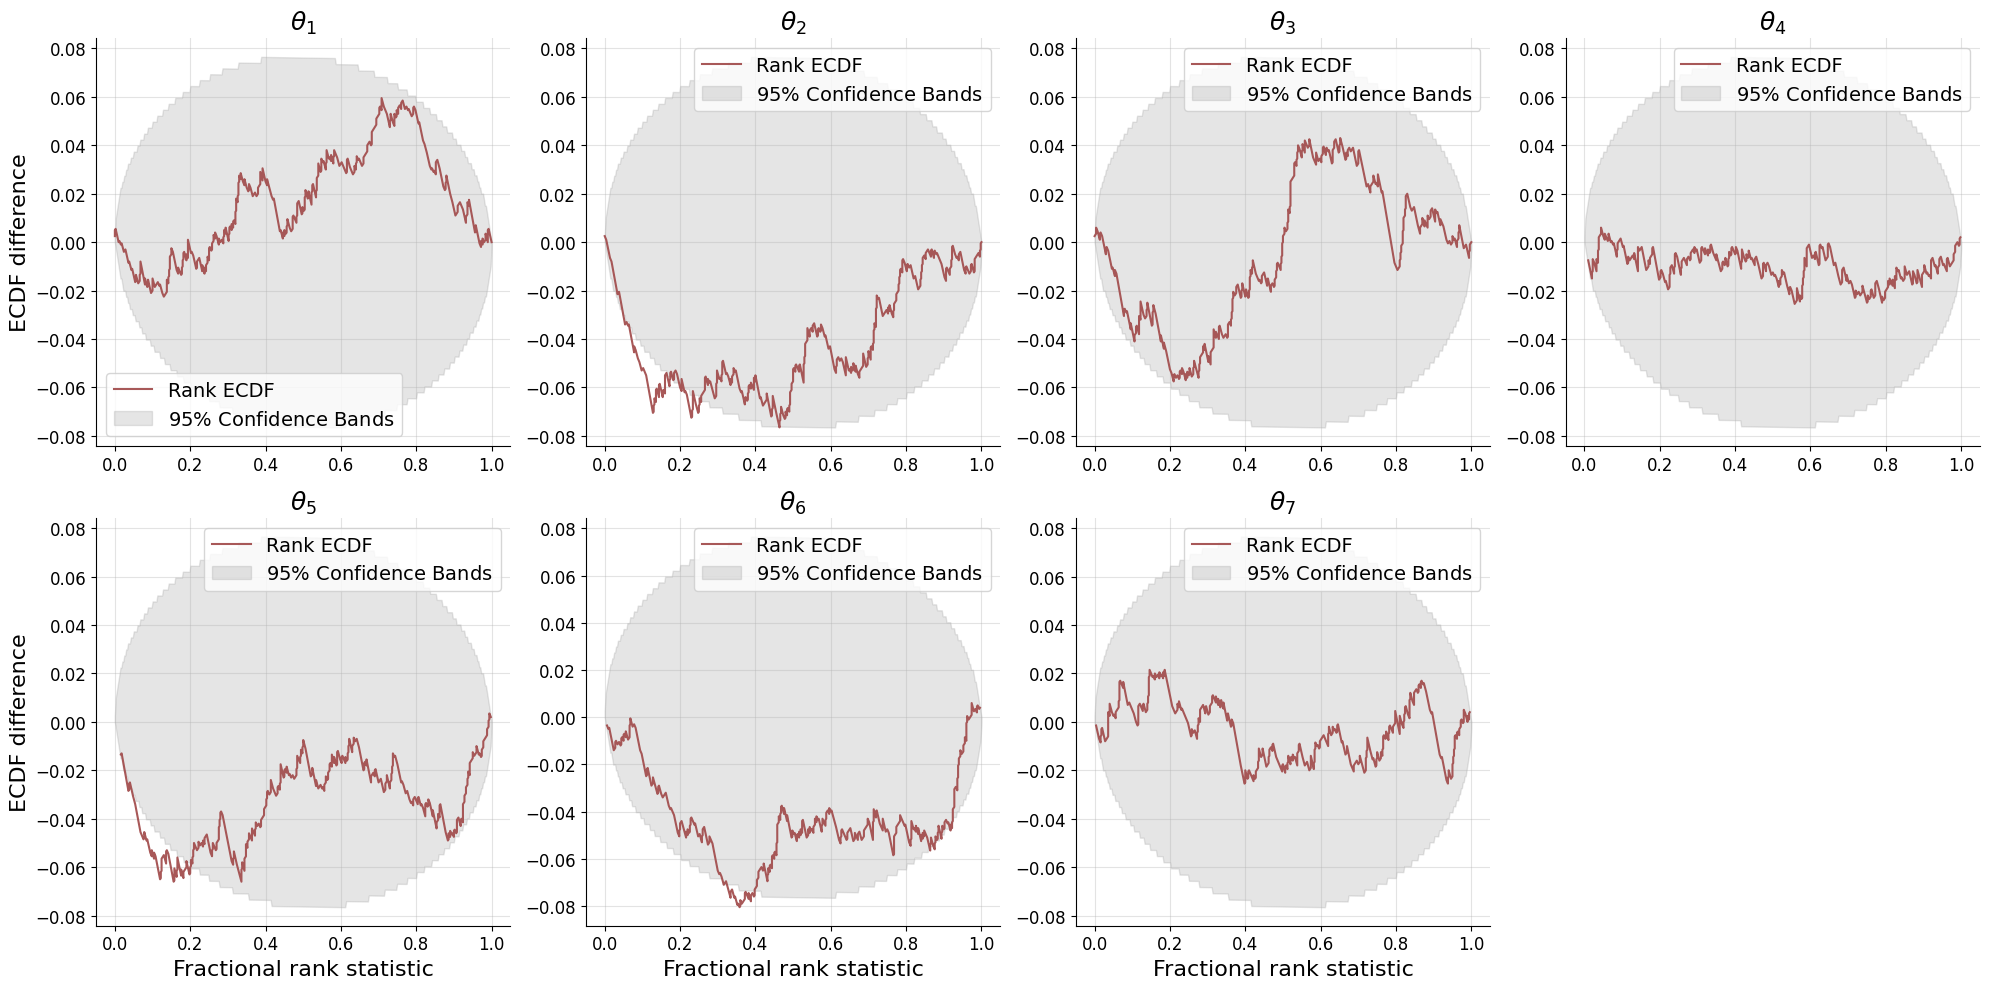

In [20]:
f = bf.diagnostics.plot_sbc_ecdf(samples, conf['parameters'], difference=True)